#Import dataset from drive (Zip File)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/Frood_Drive/D_18V3.zip

Streaming output truncated to the last 5000 lines.
  inflating: D_18V2/Train/Spoil Tomato/8_00000118.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000122.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000124.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000126.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000128.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000135.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000142.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000143.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000144.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000147.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000153.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000156.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000161.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000162.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000163.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000164.jpg  
  inflating: D_18V2/Train/Spoil Tomato/8_00000165.jpg

#Main process

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/D_18V2/Train',
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=100,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/D_18V2/Val',
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=100,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

Found 37468 files belonging to 18 classes.
Found 3872 files belonging to 18 classes.


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [6]:
class_names = train_dataset.class_names

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset).numpy())
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset).numpy())
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset).numpy())

Number of training batches: 375
Number of validation batches: 20
Number of test batches: 19


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

IMG_SHAPE = (224,224) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
base_model.trainable = False

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [11]:
prediction_layer = tf.keras.layers.Dense(18, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

In [12]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [14]:
initial_epochs = 5
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 12s 223ms/step - loss: 3.1938 - accuracy: 0.0801
initial loss: 3.19
initial accuracy: 0.08


In [15]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
375/375 [==============================] - 89s 226ms/step - loss: 1.6102 - accuracy: 0.5167 - val_loss: 0.7688 - val_accuracy: 0.8103
Epoch 2/5
375/375 [==============================] - 69s 181ms/step - loss: 0.6507 - accuracy: 0.8182 - val_loss: 0.4750 - val_accuracy: 0.8712
Epoch 3/5
375/375 [==============================] - 67s 176ms/step - loss: 0.4501 - accuracy: 0.8712 - val_loss: 0.3743 - val_accuracy: 0.8945
Epoch 4/5
375/375 [==============================] - 67s 177ms/step - loss: 0.3592 - accuracy: 0.8947 - val_loss: 0.3311 - val_accuracy: 0.9102
Epoch 5/5
375/375 [==============================] - 67s 176ms/step - loss: 0.3050 - accuracy: 0.9106 - val_loss: 0.3008 - val_accuracy: 0.9123


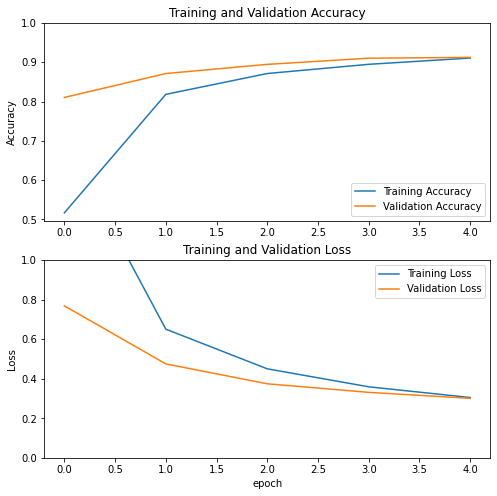

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning for better result

In [17]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [18]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [20]:
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/7
375/375 [==============================] - 96s 235ms/step - loss: 0.1801 - accuracy: 0.9381 - val_loss: 0.1987 - val_accuracy: 0.9371
Epoch 6/7
375/375 [==============================] - 82s 216ms/step - loss: 0.1023 - accuracy: 0.9667 - val_loss: 0.1935 - val_accuracy: 0.9432
Epoch 7/7
375/375 [==============================] - 82s 217ms/step - loss: 0.0693 - accuracy: 0.9773 - val_loss: 0.1747 - val_accuracy: 0.9468


In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

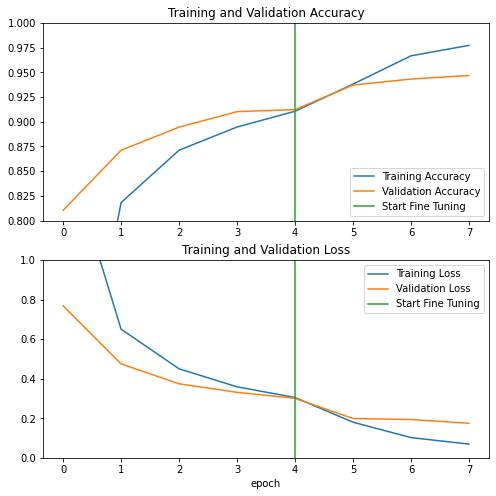

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test Model Performance with test set

In [23]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

19/19 [==============================] - 6s 220ms/step - loss: 0.1974 - accuracy: 0.9458
Test accuracy : 0.9457894563674927


Predictions:
 [13, 0, 6, 8, 16, 10, 15, 13, 17, 4, 1, 16, 11, 8, 13, 15, 16, 17, 0, 2, 0, 8, 1, 3, 5, 4, 11, 0, 8, 8, 10, 10, 16, 8, 5, 8, 5, 9, 16, 11, 1, 13, 9, 3, 4, 13, 16, 0, 10, 9, 8, 5, 2, 10, 4, 7, 17, 13, 6, 11, 9, 17, 13, 13, 11, 1, 13, 7, 10, 15, 5, 7, 15, 2, 1, 15, 13, 7, 9, 13, 5, 0, 14, 5, 4, 14, 17, 1, 15, 7, 3, 5, 10, 8, 15, 16, 17, 8, 15, 10]
Labels:
 [13, 0, 6, 17, 16, 10, 15, 13, 17, 4, 1, 16, 11, 8, 13, 15, 16, 17, 0, 2, 0, 8, 1, 3, 5, 4, 11, 0, 8, 8, 10, 10, 16, 8, 5, 8, 5, 9, 16, 11, 1, 13, 9, 3, 4, 13, 16, 0, 10, 9, 17, 5, 2, 10, 4, 7, 17, 13, 6, 11, 9, 17, 13, 13, 11, 1, 13, 7, 10, 15, 5, 7, 15, 2, 1, 15, 13, 7, 9, 13, 5, 0, 14, 5, 4, 14, 17, 1, 15, 7, 3, 5, 10, 8, 15, 16, 17, 8, 15, 10]


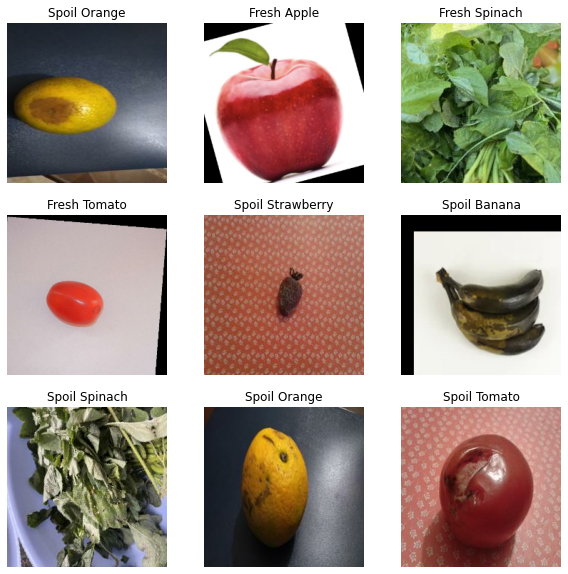

In [24]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

#Confusion matrix

In [25]:
print(len(test_dataset))

19


In [26]:
y_pred = np.array([])
y_true =  np.array([])
for x, y in test_dataset:
  y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis = -1)])
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

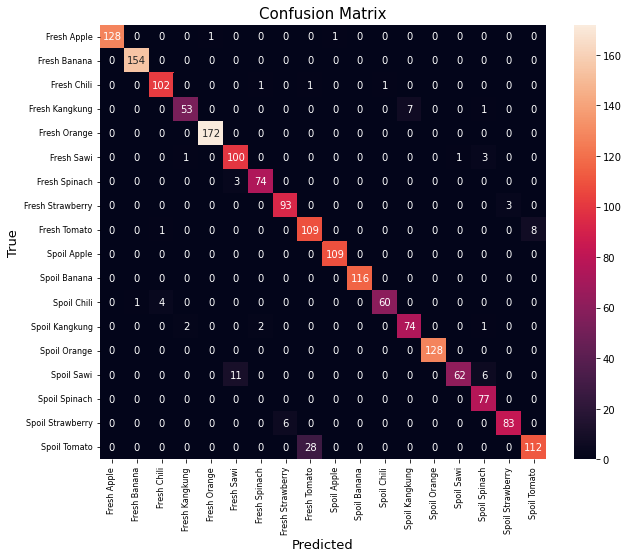

In [27]:
cm = confusion_matrix(y_true, y_pred)

fig = plt.figure(figsize=(10, 8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells

ax.set_xlabel('Predicted', fontsize=13)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 8)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=13)
ax.yaxis.set_ticklabels(class_names, fontsize = 8)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('ConMat.png')
plt.show()

#Try Model With Custom Single Image

In [ ]:
img = image.load_img(path='/content/sTom2.JPG', target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
result = model.predict(img)
print(np.round_(result*100, decimals=2))

y_pred = np.argmax(result, axis=1)
print(y_pred)
if y_pred[0] == 0:
    print("Fresh Apple : {.2f}".format(result[[ypred]]))
elif y_pred[0] == 1:
    print("Fresh Banana")
elif y_pred[0] == 2:
    print("Fresh Chilli")
elif y_pred[0] == 3:
    print("Fresh Kangkung")
elif y_pred[0] == 4:
    print("Fresh Orange")
elif y_pred[0] == 5:
    print("Fresh Sawi")
elif y_pred[0] == 6:
    print("Fresh Spinach")
elif y_pred[0] == 7:
    print("Fresh Strawberry")
elif y_pred[0] == 8:
    print("Fresh Tomato")
elif y_pred[0] == 9:
    print("Spoil Apple")
elif y_pred[0] == 10:
    print("Spoil Banana")
elif y_pred[0] == 11:
    print("Spoil Chili")
elif y_pred[0] == 12:
    print("Spoil Kangkung")
elif y_pred[0] == 13:
    print("Spoil Orange")
elif y_pred[0] == 14:
    print("Spoil Sawi")
elif y_pred[0] == 15:
    print("Spoil Spinach")
elif y_pred[0] == 16:
    print("Spoil Strawberry")
elif y_pred[0] == 17:
    print("Spoil Tomato")

NameError: ignored

#Save Model

In [28]:
model.save('/content/Model_18_No-Overfit_Acc95.h5')